# Project 1 Section 5: Denoising autoencoders

Image denoising is the process of removing noise from an image, aiming to restore it to its original quality. Various image denoising techniques exist, each with its strengths and applications. In this tutorial, we are going to focus on denoising autoencoders using the Keras library.

## Denoising Autoencoders
Denoising autoencoders involve training a neural network to learn how to remove noise from images. The autoencoder is trained to take a noisy image as input and output a clean, denoised version of the image. By learning to map noisy images to their clean counterparts, the autoencoder can effectively filter out noise, preserving essential details and improving overall image quality.

First, we create some useful functions to preprocess the images, create noisy images, and display the images. You don't need to understand these functions in detail, but you might want to have a look at how the different noisy images are created (see `noise` function)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist, cifar10
from keras.models import Model

# These are
def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    return array

def noise(array, noise_type="gaussian"):
    """Adds random noise to each image in the supplied array."""

    if noise_type == "gaussian":
        noise_factor = 0.4
        noisy_array = array + noise_factor * np.random.normal(
            loc=0.0, scale=1.0, size=array.shape
        )
        return np.clip(noisy_array, 0.0, 1.0)

    elif noise_type == "poisson":
        noisy_array = np.random.poisson(array * 255) / 255.0
        return np.clip(noisy_array, 0.0, 1.0)

    elif noise_type == "speckle":
        noise_factor = 0.4
        noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=array.shape)
        noisy_array = array + array * noise
        return np.clip(noisy_array, 0.0, 1.0)

    elif noise_type == "salt_and_pepper":

      def salt_and_pepper_noise(image):
        ratio = 0.9
        amount = 0.1
        noisy = np.copy(image)

        salt_count = np.ceil(amount * image.size * ratio)
        coords = [np.random.randint(0, i - 1, int(salt_count)) for i in image.shape]
        noisy[coords] = 1
        pepper_count = np.ceil(amount* image.size * (1. - ratio))
        coords = [np.random.randint(0, i - 1, int(pepper_count)) for i in image.shape]
        noisy[coords] = 0
        return noisy

      noisy_array = np.apply_along_axis(salt_and_pepper_noise, 0, array)
      return np.clip(noisy_array, 0.0, 1.0)


def display(*arrays):
    """Displays ten random images from each array provided."""
    n = 10  # Number of images to display from each array
    num_arrays = len(arrays)  # Number of arrays provided

    # Randomly select indices for the images
    indices = np.random.randint(len(arrays[0]), size=n)

    plt.figure(figsize=(20, 2 * num_arrays))

    for i, index in enumerate(indices):
        for j, array in enumerate(arrays):
            ax = plt.subplot(num_arrays, n, i + 1 + j * n)
            plt.imshow(array[index].squeeze())
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()



2025-02-20 20:28:12.096125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 20:28:12.096175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 20:28:12.097084: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 20:28:12.103656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 20:28:13.021479: W tensorflow/compiler/tf2

Load a subsampled dataset, preprocess the images, and create noisy versions of the original images. Then display the images.

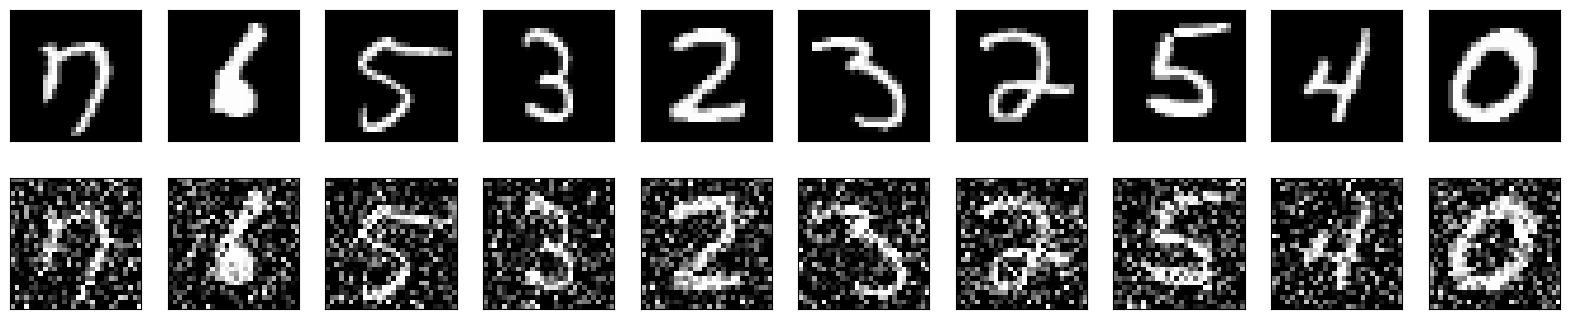

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()
image_shape = (28, 28, 1)

# Training takes too long with all images from the dataset. We only take every 20th image
subsample_fraction = 20

subsample_index_train = len(train_data)//subsample_fraction
train_data = train_data[:subsample_index_train,...]

subsample_index_test = len(test_data)//subsample_fraction
test_data = test_data[:subsample_index_test,...]

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data, noise_type = "gaussian")
noisy_test_data = noise(test_data, noise_type = "gaussian")

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

The first row contains the original images and the second row contains the noisy images. The noisy images are quite noisy, but the digits can still be recognized by human eye. Let's see if we can restore the original images given the noisy images.

Now, let's build the autoencoder. As mentioned, an autoencoder consists of two main parts: the **encoder** and the **decoder**.

**Encoder**:
The encoder is responsible for compressing the input data into a lower-dimensional representation. In this case, it starts by taking the input image (e.g., a 28x28 grayscale image) and applying a series of convolutional layers. These layers help the encoder learn important features in the image, like edges or textures, by passing the image through several filters. After each convolutional layer, pooling layers are used to reduce the size of the image, effectively compressing the data while retaining essential information.

**Decoder**:
The decoder then takes this compressed representation and tries to reconstruct the original image. It does this by gradually increasing the image's dimensions using transpose convolutional layers, which perform the opposite operation of the pooling layers in the encoder. The final layer of the decoder outputs an image that ideally resembles the original input as closely as possible.

In [3]:
input = layers.Input(shape=image_shape)

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)

2025-02-20 20:28:14.780234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-20 20:28:14.811883: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-20 20:28:14.813254: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

We train the mode using a Binary Crossentropy loss. Other loss functions like Mean Squared Error (MSE) are also possible.

In [4]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        9248  

Next, let's train the model. We train for 10 epochs, using a batch size of 128.

In [5]:
history = autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/10


2025-02-20 20:28:16.008169: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-02-20 20:28:16.109012: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-20 20:28:16.574796: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-20 20:28:19.145215: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8720fe6de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-20 20:28:19.145256: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.20gb, Compute Capability 8.0
2025-02-20 20:28:19.150395: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740083299.255520    3376 device

24/24 [==============================] - 7s 88ms/step - loss: 0.6030 - val_loss: 0.4681
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 0.4367 - val_loss: 0.3571
Epoch 3/10
24/24 [==============================] - 0s 9ms/step - loss: 0.3104 - val_loss: 0.2342
Epoch 4/10
24/24 [==============================] - 0s 9ms/step - loss: 0.2224 - val_loss: 0.1957
Epoch 5/10
24/24 [==============================] - 0s 9ms/step - loss: 0.1972 - val_loss: 0.1782
Epoch 6/10
24/24 [==============================] - 0s 9ms/step - loss: 0.1719 - val_loss: 0.1491
Epoch 7/10
24/24 [==============================] - 0s 9ms/step - loss: 0.1446 - val_loss: 0.1316
Epoch 8/10
24/24 [==============================] - 0s 9ms/step - loss: 0.1306 - val_loss: 0.1238
Epoch 9/10
24/24 [==============================] - 0s 9ms/step - loss: 0.1245 - val_loss: 0.1209
Epoch 10/10
24/24 [==============================] - 0s 9ms/step - loss: 0.1209 - val_loss: 0.1173


The first row shows the original image, the second row shows the images with added noise. The third row displays the images with removed noise by the denoising autoencoder.

We can see that the edges of the denoised images are not as sharp as the edges of the original image. Hence, the autoencoder denoises the images by smoothing the edges.

16/16 [==============================] - 1s 29ms/step


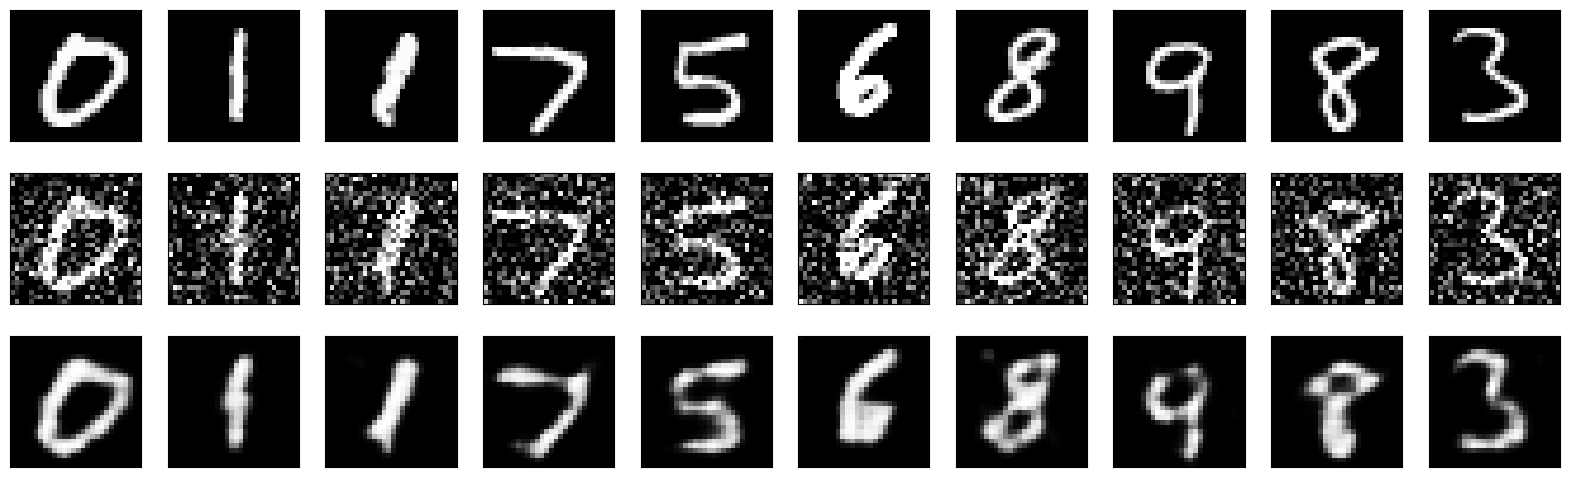

In [6]:
predictions = autoencoder.predict(noisy_test_data)
display(test_data, noisy_test_data, predictions)

### Assessment task

Modify the Denoising Autoencoder to work with color images by using the CIFAR-10 dataset. Train the model to remove noise from these colored images and visualize the denoising results. Compare the performance of your modified autoencoder with the original model trained on grayscale images. You can

Start by replacing `mnist.load_data()` with `cifar10.load_data()`. Then, modify the autoencoder architecture, such that the model can be trained with the new dataset. Finally, compare the results with the result from the original model qualitatively. How does the auotencoder perform on the CIFAR-10 dataset? Which parameters can we change to improve the performance?